# Clustering & Topics

In [1]:
import pandas as pd
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import nltk

import numpy as np #for arrays
import pandas #gives us DataFrames


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [2]:
pubmed = pd.read_csv('pubmed_psyc.csv')

# Network  
### Co-occurances of meaningful nouns are counted to create networks. The edges are weighted on the total count of occurances of both words.

In [4]:
# select the past 5 years of abstract
pubmed15 = pubmed[(pubmed['pubdate'] == 2015)]
pubmed16 = pubmed[(pubmed['pubdate'] == 2016)]
pubmed17 = pubmed[(pubmed['pubdate'] == 2017)]
pubmed18 = pubmed[(pubmed['pubdate'] == 2018)]
pubmed19 = pubmed[(pubmed['pubdate'] == 2019)]

## 2015

In [6]:
# tokenize and normalize words
pubmed15['tokenized_text'] = pubmed15['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pubmed15['normalized_tokens'] = pubmed15['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
pubmed15['normalized_tokens']

177225    [study, explore, musculoskeletal, complaint, r...
178699    [introduction, american, continent, rich, psyc...
181936    [factor, analysis, model, parsimoniously, redu...
182722    [objective, development, reliable, questionnai...
184379    [introduction, age, common, background, dement...
                                ...                        
286835    [background, marathon, runner, experience, dif...
286836    [background, tape, widely, field, rehabilitati...
289187    [adams, andrew, mcconnell, widely, credit, neu...
290613    [child, bear, preterm, risk, wide, range, neur...
290742    [approach, reward, avoid, punishment, consider...
Name: normalized_tokens, Length: 13958, dtype: object

In [25]:
# we'd like to filter out all abstracts with the word "alzheimer" in them
pubmed15['alz_count'] = pubmed15['normalized_tokens'].apply(lambda x: x.count('alzheimer'))
pubmed_alz15 = pubmed15[pubmed15['alz_count'] > 0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
pubmed_alz15 = pubmed15[pubmed15['alz_count'] > 0]

In [27]:
# we then use nltk to get nouns
pubmed_alz15['pos'] = pubmed_alz15['normalized_tokens'].apply(lambda x: nltk.pos_tag(x))
pubmed_alz15['pos']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


184379    [(introduction, NN), (age, NN), (common, JJ), ...
198769    [(objective, JJ), (test, NN), (hypothesis, NN)...
201058    [(examine, NN), (ground, NN), (optimism, IN), ...
201069    [(capgras, NNS), (delusion, NN), (characterize...
206983    [(recent, JJ), (research, NN), (alzheimer, NN)...
                                ...                        
249884    [(acquire, VB), (brain, NN), (injury, NN), (ab...
257512    [(exercise, NN), (improve, VB), (cognitive, JJ...
259566    [(ample, JJ), (evidence, NN), (heterogeneous, ...
259921    [(age, NN), (dependent, JJ), (cognitive, JJ), ...
261702    [(piperine, NN), (pip, JJ), (phytopharmaceutic...
Name: pos, Length: 783, dtype: object

In [45]:
noun_count = {}
for index, row in pubmed_alz15.iterrows():
    for word in row['pos']:
        if word[1] == 'NN':
            if word[0] not in noun_count:
                 noun_count[word[0]] = 0
            if word[0] in noun_count:
                noun_count[word[0]] += 1


In [132]:
filter_word = ['control', 'group', 'level', 'effect', 'activity', 'study', 'patient', 'result', 
               'ad', 'disease', 'increase', 'model', 'analysis', 'function', 'method', 'mechanism',
              'test', 'role', 'disorder', 'change', 'base', 'risk', 'show', 'factor', 'p', 'datum',
              'conclusion', 'measure', 'association', 'process', 'year', 'target', 'relate']

In [101]:
# a minimal count of 270 is selected to extract only the top 10-20 frequent nouns
import networkx as nx
alz15_network = nx.Graph()

for index, row in pubmed_alz15.iterrows():
    for word in row['pos']:
        if word[1] == 'NN':
            if (noun_count[word[0]] > 270) & (word[0] not in filter_word):
                alz15_network.add_node(word[0])
len(alz15_network.nodes())

10

In [102]:
import itertools
edge_weight = {}
for pair in list(itertools.combinations(alz15_network.nodes(), 2)):
    edge_weight[pair] = 0
    
for index, row in pubmed_alz15.iterrows():
    for pair, weight in edge_weight.items():
        if (pair[0] in row['normalized_tokens']) & (pair[1] in row['normalized_tokens']):
            edge_weight[pair] += row['normalized_tokens'].count(pair[0]) + row['normalized_tokens'].count(pair[1])

In [103]:
for pair, weight in edge_weight.items():
    alz15_network.add_edge(pair[0], pair[1], weight = edge_weight[pair])


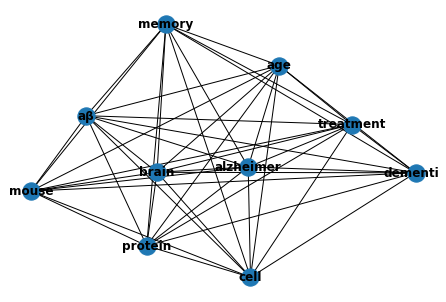

In [104]:
nx.draw(alz15_network, with_labels=True, font_weight='bold')

## 2016

In [123]:
def draw_network(df):
    df['tokenized_text'] = df['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
    df['alz_count'] = df['normalized_tokens'].apply(lambda x: x.count('alzheimer'))
    df_alz = df[df['alz_count'] > 0]
    df_alz['pos'] = df_alz['normalized_tokens'].apply(lambda x: nltk.pos_tag(x))
    
    noun_count = {}
    for index, row in df_alz.iterrows():
        for word in row['pos']:
            if word[1] == 'NN':
                if word[0] not in noun_count:
                     noun_count[word[0]] = 0
                if word[0] in noun_count:
                    noun_count[word[0]] += 1
    
    network = nx.Graph()

    for index, row in df_alz.iterrows():
        for word in row['pos']:
            if word[1] == 'NN':
                if (noun_count[word[0]] > 270) & (word[0] not in filter_word):
                    network.add_node(word[0])
    
    edge_weight = {}
    for pair in list(itertools.combinations(network.nodes(), 2)):
        edge_weight[pair] = 0

    for index, row in df_alz.iterrows():
        for pair, weight in edge_weight.items():
            if (pair[0] in row['normalized_tokens']) & (pair[1] in row['normalized_tokens']):
                edge_weight[pair] += row['normalized_tokens'].count(pair[0]) + row['normalized_tokens'].count(pair[1])
                
    for pair, weight in edge_weight.items():
        network.add_edge(pair[0], pair[1], weight = edge_weight[pair])

    nx.draw(network, with_labels=True, font_weight='bold')

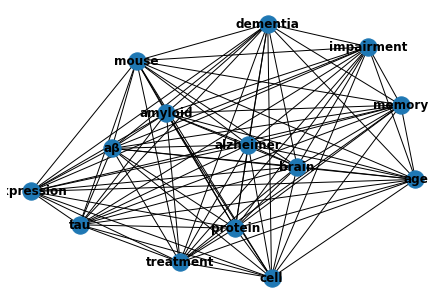

In [114]:
draw_network(pubmed16)

## 2017

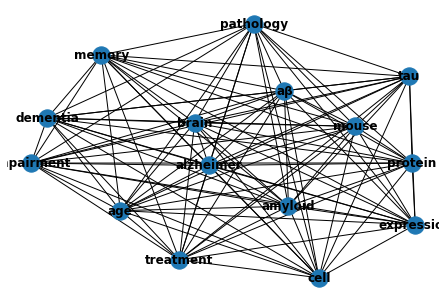

In [117]:
draw_network(pubmed17)

## 2018

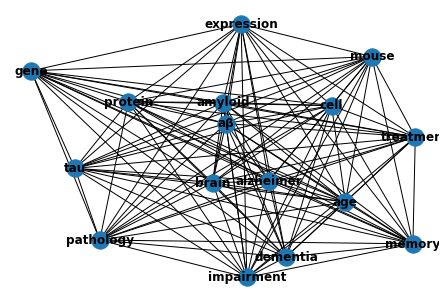

In [126]:
draw_network(pubmed18)

## 2019

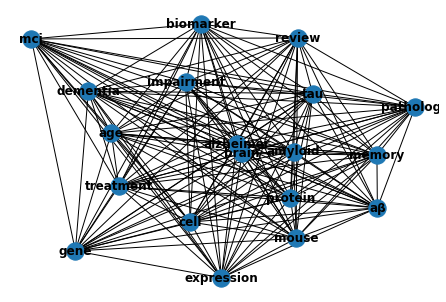

In [133]:
draw_network(pubmed19)

# Text Generation  
### Using a gpt2 pretrained model, we fine-tuned the model with abstracts in 1989, 1999, 2009 and 2019 and generated text with the 4 fine-tuned models.

In [2]:
from transformers import AutoModelWithLMHead, AutoTokenizer
# load the pretrained model
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [3]:
# select years
pubmed89 = pubmed[(pubmed['pubdate'] == 1989)]
pubmed99 = pubmed[(pubmed['pubdate'] == 1999)]
pubmed09 = pubmed[(pubmed['pubdate'] == 2009)]
pubmed19 = pubmed[(pubmed['pubdate'] == 2019)]

In [4]:
from sklearn.model_selection import train_test_split
pubmed89_train, pubmed89_test = train_test_split(pubmed89['abstract'], test_size=0.2)
pubmed99_train, pubmed99_test = train_test_split(pubmed99['abstract'], test_size=0.2)
pubmed09_train, pubmed09_test = train_test_split(pubmed09['abstract'], test_size=0.2)
pubmed19_train, pubmed19_test = train_test_split(pubmed19['abstract'], test_size=0.2)

In [5]:
# save training text
pubmed89_train.to_frame().to_csv(r'pubmed89_train', header=None, index=None, sep=' ', mode='a')
pubmed99_train.to_frame().to_csv(r'pubmed99_train', header=None, index=None, sep=' ', mode='a')
pubmed09_train.to_frame().to_csv(r'pubmed09_train', header=None, index=None, sep=' ', mode='a')
pubmed19_train.to_frame().to_csv(r'pubmed19_train', header=None, index=None, sep=' ', mode='a')

In [7]:
# save test text
pubmed89_test.to_frame().to_csv(r'pubmed89_test', header=None, index=None, sep=' ', mode='a')
pubmed99_test.to_frame().to_csv(r'pubmed99_test', header=None, index=None, sep=' ', mode='a')
pubmed09_test.to_frame().to_csv(r'pubmed09_test', header=None, index=None, sep=' ', mode='a')
pubmed19_test.to_frame().to_csv(r'pubmed19_test', header=None, index=None, sep=' ', mode='a')

Models are trained on Google Colab with a GPU and downloaded.

In [9]:
from transformers import AutoModelWithLMHead, AutoTokenizer
tokenizer_89 = AutoTokenizer.from_pretrained("output_gpt_pubmed89")
model_89 = AutoModelWithLMHead.from_pretrained("output_gpt_pubmed89")

In [22]:
# we first give a context-specific prompt
sequence = "Alzheimer is a disease"

input = tokenizer_89.encode(sequence, return_tensors="pt")
generated = model_89.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_89.decode(generated.tolist()[0])
print(resulting_string)

Alzheimer is a disease of the brain that affects the brain's ability to process information. It is a neurodegenerative disease that affects the brain's ability to process information. It is a neurodegenerative disease that affects the brain's


In [37]:
# we then use a common prompt
sequence = "Rats are"

input = tokenizer_89.encode(sequence, return_tensors="pt")
generated = model_89.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_89.decode(generated.tolist()[0])
print(resulting_string)

Rats are a group of mammals that are closely related to the mammalian gut. They are characterized by a wide range of physiological and behavioral characteristics, including a high degree of neuroendocrine activity, a high degree of neuroendocrine activity, and a


In [17]:
tokenizer_99 = AutoTokenizer.from_pretrained("output_gpt_pubmed99")
model_99 = AutoModelWithLMHead.from_pretrained("output_gpt_pubmed99")

In [23]:
sequence = "Alzheimer is a disease"

input = tokenizer_99.encode(sequence, return_tensors="pt")
generated = model_99.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_99.decode(generated.tolist()[0])
print(resulting_string)

Alzheimer is a disease of the brain that affects the central nervous system. It is a neurodegenerative disease of the brain that affects the central nervous system. It is a neurodegenerative disease of the brain that affects the central nervous


In [38]:
sequence = "Rats are"

input = tokenizer_99.encode(sequence, return_tensors="pt")
generated = model_99.generate(input, max_length=80, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_99.decode(generated.tolist()[0])
print(resulting_string)

Rats are a rare group of mammals that have been identified as having a high degree of neuroendocrine function. The purpose of this study was to determine the neuroendocrine function of the rat brain in response to stress and to determine the neuroendocrine function of the rat brain in response to stress-induced stress. Rats were subjected to a series of stress-induced stress-induced stress-induced


In [26]:
tokenizer_09 = AutoTokenizer.from_pretrained("output_gpt_pubmed09")
model_09 = AutoModelWithLMHead.from_pretrained("output_gpt_pubmed09")

In [28]:
sequence = "Alzheimer is a disease"

input = tokenizer_09.encode(sequence, return_tensors="pt")
generated = model_09.generate(input, max_length=80, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_09.decode(generated.tolist()[0])
print(resulting_string)

Alzheimer is a disease of the brain that affects the brain's ability to process information. The disease is characterized by a progressive loss of the ability to process information. The disease is associated with a wide range of neurological and psychiatric disorders, including Alzheimer's disease, Parkinson's disease, Huntington's disease, Huntington's disease, Huntington's disease, Huntington's disease, Huntington's disease, Huntington's disease


In [39]:
sequence = "Rats are"

input = tokenizer_09.encode(sequence, return_tensors="pt")
generated = model_09.generate(input, max_length=80, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_09.decode(generated.tolist()[0])
print(resulting_string)

Rats are a rare group of vertebrates that have been studied extensively in the laboratory. The purpose of this study was to investigate the relationship between the expression of the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding the genes encoding


In [33]:
tokenizer_19 = AutoTokenizer.from_pretrained("output_gpt_pubmed19")
model_19 = AutoModelWithLMHead.from_pretrained("output_gpt_pubmed19")

In [34]:
sequence = "Alzheimer is a disease"

input = tokenizer_19.encode(sequence, return_tensors="pt")
generated = model_19.generate(input, max_length=80, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_19.decode(generated.tolist()[0])
print(resulting_string)

Alzheimer is a disease of the central nervous system that affects the brain and spinal cord. It is a neurodegenerative disease of the central nervous system that affects the brain and spinal cord. It is a neurodegenerative disease of the central nervous system that affects the brain and spinal cord. It is a neurodegenerative disease of the central nervous system that affects the brain and spinal


In [40]:
sequence = "Rats are"

input = tokenizer_19.encode(sequence, return_tensors="pt")
generated = model_19.generate(input, max_length=100, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_19.decode(generated.tolist()[0])
print(resulting_string)

Rats are a group of rare and rare diseases that are characterized by a wide range of symptoms, including neurodevelopmental disorders, neurodegenerative disorders, and neurodegenerative disorders. The most common cause of death is the loss of the central nervous system (CNS), which is a major cause of disability and death. The most common cause of death is the loss of the central nervous system (CNS), which is a major cause of disability and death. The most common cause of
